In [14]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def weights_vert_coarse_grain_fl(zh_lr_vals, zh_hr_vals):
    """
    Some vertical integrals in ICON are approximated by the sum over vertical levels.
    For the vertical integral on vertically coarse grained data, you need weights to
    count a coarse level more than once because multiple high resolution levels can 
    be in one coarse level. 
    Args:
        zh_lr_vals: height at half levels of low resolution (height, cell)
        zh_hr_vals: height at half levels of high resolution (height, cell)
    
    Return:
        result: number of high-res cells in coarse cells including fractions
    """
    # create array of target shape
    result = np.zeros((zh_lr_vals.shape[0]-1, zh_lr_vals.shape[1])) 
    # iterate through low resolution height levels
    for j in range(zh_lr_vals.shape[0]-1): 
        # note: ICON starts at the top --> lower bound at j+1
        z_u = zh_lr_vals[j,:]     # upper bound of current height level
        z_l = zh_lr_vals[j+1,:]   # lower bound of current height level 

        # find all high res layers that are fully contained in coarse layer j
        # layer border is upper and lower layer in coarse layer
        hinc = np.where((z_l<= zh_hr_vals) & (zh_hr_vals <=z_u), 1, 0)
        # two layer for one cell, so subtract 1
        full_in_c = np.sum(hinc, axis=0)-1
        # calculate fraction of overlapping cells
        # 1. get the distance from below to upper bound
        h_below_u = -1*np.max(np.where(zh_hr_vals<z_u, zh_hr_vals-z_u, -z_u), axis=0)
        # 2. get the distance from above to upper bound
        h_above_u = np.min(np.where(zh_hr_vals>z_u, zh_hr_vals-z_u, z_u), axis=0)
        fraction_u = np.where(h_above_u!=z_u, h_below_u/(h_above_u+h_below_u), 0)
        # 1. get the distance from below to lower bound
        h_below_l = -1*np.max(np.where(zh_hr_vals<z_l, zh_hr_vals-z_l, -z_l), axis=0)
        # 2. get the distance from above to lower bound
        h_above_l = np.min(np.where(zh_hr_vals>z_l, zh_hr_vals-z_l, z_l), axis=0)
        fraction_l = np.where(h_below_l!=z_l, h_above_l/(h_above_l+h_below_l), 0)
        
        result[j,:] = full_in_c + fraction_l + fraction_u
    return result

In [188]:
def weights_vert_coarse_grain_fl(zh_lr_vals, zh_hr_vals):
    """
    Some vertical integrals in ICON are approximated by the sum over vertical levels.
    For the vertical integral on vertically coarse grained data, you need weights to
    count a coarse level more than once because multiple high resolution levels can 
    be in one coarse level. 
    Args:
        zh_lr_vals: height at half levels of low resolution (height, cell)
        zh_hr_vals: height at half levels of high resolution (height, cell)
    
    Return:
        result: number of high-res cells in coarse cells including fractions
    """
    # create array of target shape
    result = np.zeros((zh_lr_vals.shape[0]-1, zh_lr_vals.shape[1])) 
    # iterate through low resolution height levels
    for j in range(zh_lr_vals.shape[0]-1): 
        # note: ICON starts at the top --> lower bound at j+1
        z_u = zh_lr_vals[j,:]     # upper bound of current height level
        z_l = zh_lr_vals[j+1,:]   # lower bound of current height level 
      
        weights = np.maximum(np.minimum(z_u, zh_hr_vals[:-1]) - np.maximum(zh_hr_vals[1:], z_l), 0)
        # find all high res layers that are fully contained in coarse layer j
        # layer border is upper and lower layer in coarse layer
        hinc = np.where((z_l<= zh_hr_vals) & (zh_hr_vals <=z_u), 1, 0)
        # it counts both boundaries of one cell, so subtract 1
        full_in_c = np.sum(hinc, axis=0)-1
        # calculate fraction of overlapping cells
        # 1. get the distance from below to upper bound
        d_below_u = np.min(-np.where(zh_hr_vals<z_u, zh_hr_vals-z_u, -1e7), axis=0)
        # 2. get the distance from above to upper bound
        d_above_u = np.min(np.where(zh_hr_vals>z_u, zh_hr_vals-z_u, 1e7), axis=0)
        fraction_u = np.where(d_above_u!=z_u, d_below_u/(d_above_u+d_below_u), 0)
        # 1. get the distance from below to lower bound
        d_below_l = np.min(-np.where(zh_hr_vals<z_l, zh_hr_vals-z_l, -1e7), axis=0)
        #d_below_l = -1*np.max(np.where((zh_hr_vals<z_l)&(z_l<0), -zh_hr_vals+z_l, d_below_l), axis=0)
        # 2. get the distance from above to lower bound
        d_above_l = np.min(np.where(zh_hr_vals>z_l, zh_hr_vals-z_l, 1e7), axis=0)
        fraction_l = np.where(d_below_l!=z_l, d_above_l/(d_above_l+d_below_l), 0)
        
        result[j,:] = full_in_c + fraction_l + fraction_u 
        result[j,:] = np.where((np.abs((z_u - z_l) - np.sum(weights, axis = 0))) >= 0.5, np.nan, result[j,:])
    return result

In [189]:
zh_lr_path = "/p/project1/icon-a-ml/hafner1/org_radiation/preprocessing/atm_amip_R2B5_vgrid_ml.nc"
zh_hr_path = "/p/project1/icon-a-ml/hafner1/zhalf_192.nc"
zh_hr_ds = xr.open_mfdataset(zh_hr_path)
zh_hr = zh_hr_ds["zhalf"].values
zh_lr_ds = xr.open_mfdataset(zh_lr_path)
zh_lr = zh_lr_ds["zhalf"].values


weights = weights_vert_coarse_grain_fl(zh_lr, zh_hr)

78069


array([190.6972421 , 190.60466702, 190.57286443, 190.6146219 ,
       190.54526186, 190.59332449, 190.6342809 , 190.69791136,
       190.68824565, 190.63287137, 190.54013744, 190.63543622,
       190.64117406, 190.65067368, 190.60106877, 190.65945261,
       190.65207785, 190.66500378, 190.69584899, 190.6170575 ,
       190.66814701, 190.60553857, 190.66761049, 190.60286128,
       190.6865713 , 190.69478017, 190.6912782 , 190.54476428,
       190.65081226, 190.68203304, 190.66910374, 190.68789838,
       190.47851456, 190.63895868, 190.65284759, 190.68272227,
       190.66973021, 190.56559361, 190.5637589 , 190.67465837])

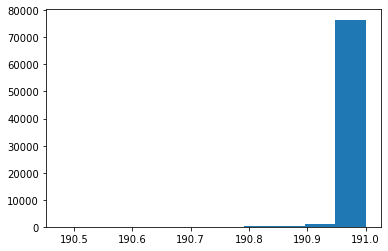

In [205]:
sw = weights[:,~np.isnan(weights[-1])].sum(axis=0)
print(len(sw))
plt.hist(sw)
sw[np.abs(sw-191)>3e-1]

In [193]:
np.sum(np.isnan(weights[-1]))

3851

In [21]:
weights.shape

(47, 81920)

In [187]:
np.save("weights_vert_integral_on_cg.npy", weights)

(47, 81920)


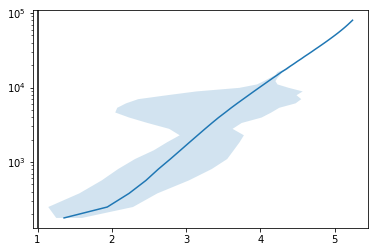

In [183]:
vweights = weights
print(vweights.shape)
z = zh_lr_ds["zfull"].isel({ "ncells":0}).values
plt.fill_betweenx(z, np.nanmin(vweights, axis=1), np.nanmax(vweights,axis=1), alpha=0.2)
plt.plot(np.nanmean(vweights,axis=1), z)
plt.yscale("log")
plt.axvline(1, c="black")

In [186]:
np.nanmin(weights)

1.1448190380590442

In [47]:
len(weights[-1][weights[-1]==0])

27

(array([1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        3.0000e+00, 3.0000e+00, 1.0000e+00, 0.0000e+00, 3.0000e+00,
        1.0000e+00, 2.0000e+00, 1.0000e+00, 2.0000e+00, 4.0000e+00,
        1.0000e+00, 4.0000e+00, 1.1000e+01, 7.0000e+00, 1.1000e+01,
        8.0000e+00, 1.2000e+01, 6.0000e+00, 1.6000e+01, 2.1000e+01,
        1.4000e+01, 1.4000e+01, 1.3000e+01, 2.5000e+01, 4.8000e+01,
        3.8000e+01, 5.4000e+01, 6.6000e+01, 9.8000e+01, 1.1900e+02,
        1.3600e+02, 1.8400e+02, 2.3400e+02, 3.7200e+02, 4.7100e+02,
        6.8100e+02, 1.1860e+03, 2.4470e+03, 6.3348e+04, 6.5130e+03,
        2.0820e+03, 9.8800e+02, 6.3900e+02, 4.7300e+02, 3.2300e+02,
        2.2900e+02, 1.9400e+02, 1.4500e+02, 9.9000e+01, 8.9000e+01,
        8.0000e+01, 5.1000e+01, 5.4000e+01, 4.6000e+01, 3.3000e+01,
        2.8000e+01, 2.5000e+01, 2.5000e+01, 1.1000e+01, 1.7000e+01,
        1.1000e+01, 1.2000e+01, 7.0000e+00, 1.00

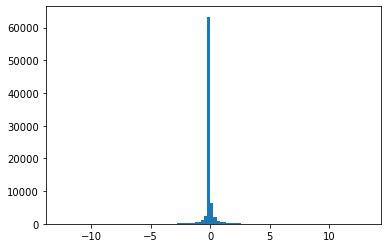

In [208]:
plt.hist((zh_lr[-1]-zh_hr[-1]), bins=100)

In [220]:
selected_surface = np.where(np.abs(zh_lr[-1]-zh_hr[-1])>0.1,np.nan,zh_lr_ds.ncells.values)
selected_surface = selected_surface[~np.isnan(selected_surface)]
len(selected_surface)

63547

In [221]:
np.save("surface_cells.npy", selected_surface)

In [217]:
zh_lr_ds

<xarray.Dataset>
Dimensions:        (ncells: 81920, vertices: 3, height: 47, bnds: 2,
                    height_2: 48, time: 1)
Coordinates:
    clon           (ncells) float32 dask.array<chunksize=(81920,), meta=np.ndarray>
    clat           (ncells) float32 dask.array<chunksize=(81920,), meta=np.ndarray>
  * height         (height) float64 1.0 2.0 3.0 4.0 5.0 ... 44.0 45.0 46.0 47.0
  * height_2       (height_2) float64 1.0 2.0 3.0 4.0 ... 45.0 46.0 47.0 48.0
  * time           (time) float64 1.979e+07
Dimensions without coordinates: ncells, vertices, bnds
Data variables: (12/16)
    clon_bnds      (ncells, vertices) float32 dask.array<chunksize=(81920, 3), meta=np.ndarray>
    clat_bnds      (ncells, vertices) float32 dask.array<chunksize=(81920, 3), meta=np.ndarray>
    height_bnds    (height, bnds) float64 dask.array<chunksize=(47, 2), meta=np.ndarray>
    height_2_bnds  (height_2, bnds) float64 dask.array<chunksize=(48, 2), meta=np.ndarray>
    zg             (height, ncells) float32 dask.array<chunksize=(47, 81920), meta=np.ndarray>
    zhalf          (height_2, ncells) float32 dask.array<chunksize=(48, 81920), meta=np.ndarray>
    ...             ...
    sftgif         (ncells) float32 dask.array<chunksize=(81920,), meta=np.ndarray>
    sftof          (ncells) float32 dask.array<chunksize=(81920,), meta=np.ndarray>
    land           (time, ncells) float32 dask.array<chunksize=(1, 81920), meta=np.ndarray>
    alake          (time, ncells) float32 dask.array<chunksize=(1, 81920), meta=np.ndarray>
    glac           (time, ncells) float32 dask.array<chunksize=(1, 81920), meta=np.ndarray>
    lake_ice_frc   (time, ncells) float32 dask.array<chunksize=(1, 81920), meta=np.ndarray>
Attributes:
    CDI:                  Climate Data Interface version 1.8.3rc (http://mpim...
    Conventions:          CF-1.6
    number_of_grid_used:  19
    grid_file_uri:        http://icon-downloads.mpimet.mpg.de/grids/public/mp...
    uuidOfHGrid:          e941b1d0-ab58-11e8-ba4f-bdd1e82b9e6d
    uuidOfVGrid:          4445bda3-b69f-3e80-ceeb-8529cda62aa0
    institution:          Max Planck Institute for Meteorology/Deutscher Wett...
    title:                ICON simulation
    source:               https://gitlab.dkrz.de/icon-ml/icon_developments/ic...
    history:              /work/bd1179/b381837/icon-2-6-4/icon-2-6-4_levante/...
    references:           see MPIM/DWD publications
    comment:              Katharina Hafner (b381837) on l10709 (Linux 4.18.0-...

In [218]:
len(selected_surface)

74276